In [111]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [112]:
def max_freq_decorrelation(
    freq_resolution_hz,
    max_bl_length_m,
    source_za = np.pi/2,
    c = 3e8,
):
    return 1 - np.sinc(
        freq_resolution_hz * max_bl_length_m / c * np.sin(source_za)
    )  # Note that the numpy sinc function is \sin(\pi x)/(\pi x)


def time_decorrelation(
    time_resolution_s,
    freq_hz,
    bl_ew_extent_m,
    bl_ns_extent_m,
    source_ra_offset_hr,  # Difference between zenith and source RAs
    source_dec_deg,  # Difference between zenith and source RAs
    telescope_lat_deg=39.25,
    omega=7.27e-5,
    c=3e8,
):
    source_dec_rad = np.deg2rad(source_dec_deg)
    source_ra_offset_rad = source_ra_offset_hr / 12 * np.pi
    zenith_dec_rad = np.deg2rad(telescope_lat_deg)
    u = bl_ew_extent_m * freq_hz / c
    v = bl_ns_extent_m * freq_hz / c
    sinc_arg = (
        time_resolution_s
        * omega
        * np.cos(source_dec_rad)
        * (
            u * np.cos(source_ra_offset_rad)
            - v * np.sin(zenith_dec_rad) * np.sin(source_ra_offset_rad)
        )
    )  # Note that the numpy sinc function is \sin(\pi x)/(\pi x)
    return 1 - np.sinc(sinc_arg)


def time_decorrelation_with_continuous_phase_tracking(
    time_resolution_s,
    freq_hz,
    bl_ew_extent_m,
    bl_ns_extent_m,
    source_ra_offset_hr,  # Difference between zenith and source RAs
    source_dec_deg,  # Difference between zenith and source RAs
    telescope_lat_deg=39.25,
    omega=7.27e-5,
    c=3e8,
):
    source_dec_rad = np.deg2rad(source_dec_deg)
    source_ra_offset_rad = source_ra_offset_hr / 12 * np.pi
    zenith_dec_rad = np.deg2rad(telescope_lat_deg)
    u = bl_ew_extent_m * freq_hz / c
    v = bl_ns_extent_m * freq_hz / c
    sinc_arg = (
        time_resolution_s
        * omega
        * (
            u * np.cos(source_dec_rad) * np.cos(source_ra_offset_rad)
            - u * np.cos(zenith_dec_rad)
            - v * np.cos(source_dec_rad) * np.sin(zenith_dec_rad) * np.sin(source_ra_offset_rad)
        )
    )  # Note that the numpy sinc function is \sin(\pi x)/(\pi x)
    return 1 - np.sinc(sinc_arg)


def time_decorrelation_with_discrete_phase_tracking(
    total_time_interval_s,
    n_time_steps,
    freq_hz,
    bl_ew_extent_m,
    bl_ns_extent_m,
    source_ra_offset_hr,  # Difference between zenith and source RAs
    source_dec_deg,  # Difference between zenith and source RAs
    telescope_lat_deg=39.25,
    omega=7.27e-5,
    c=3e8,
):
    source_dec_rad = np.deg2rad(source_dec_deg)
    source_ra_offset_rad = source_ra_offset_hr / 12 * np.pi
    zenith_dec_rad = np.deg2rad(telescope_lat_deg)
    u = bl_ew_extent_m * freq_hz / c
    v = bl_ns_extent_m * freq_hz / c

    phase_tracking_interval_s = total_time_interval_s / n_time_steps
    sinc_arg = (
        phase_tracking_interval_s
        * omega
        * np.cos(source_dec_rad)
        * (
            np.cos(source_ra_offset_rad) * u
            - np.sin(zenith_dec_rad) * np.sin(source_ra_offset_rad) * v
        )
    )  # Note that the numpy sinc function is \sin(\pi x)/(\pi x)

    n_array = np.arange(
        -(float(n_time_steps) - 1) / 2,
        (float(n_time_steps) - 1) / 2 + 1, 
        1
    )

    exp_term = 0
    for n in n_array:
        exp_arg = (
            n
            * phase_tracking_interval_s
            * omega
            * (
                1 * np.cos(source_dec_rad) * np.cos(source_ra_offset_rad) * u
                - np.cos(zenith_dec_rad) * u
                - np.cos(source_dec_rad)
                * np.sin(zenith_dec_rad)
                * np.sin(source_ra_offset_rad)
                * v
            )
        )
        exp_term += np.real(np.exp(2 * np.pi * 1j * exp_arg))
    decorr = 1 - (1/float(n_time_steps)) * exp_term * np.sinc(sinc_arg)

    return decorr

In [182]:
def az_za_to_ra_dec(
    az_vals,  # Units degrees
    za_vals,  # Units degrees
    ra_zenith,  # Units hours
    dec_zenith,  # Units degrees
):
    ra_vals = ra_zenith - np.arctan2(
        np.sin(np.deg2rad(dec_zenith)) * np.sin(np.deg2rad(za_vals)) * np.sin(np.deg2rad(az_vals))
        - np.cos(np.deg2rad(dec_zenith)) * np.cos(np.deg2rad(za_vals)),
        np.sin(np.deg2rad(za_vals) * np.cos(np.deg2rad(az_vals)))
    )/np.pi*12 - 6  # Units hours
    dec_vals = 90 - np.rad2deg(np.arccos(
        np.cos(np.deg2rad(dec_zenith))
        * np.sin(np.deg2rad(za_vals))
        * np.sin(np.deg2rad(az_vals))
        + np.sin(np.deg2rad(dec_zenith)) * np.cos(np.deg2rad(za_vals))
    ))  # Units degrees
    return ra_vals, dec_vals

def make_polar_contour_plot(
    plot_vals,
    az_vals,  # Units radians
    za_vals,  # Units degrees
    vmin=-1,
    vmax=1,
    ncontours=11,
    title="",
):
    use_cmap = matplotlib.cm.get_cmap("inferno").copy()
    use_cmap.set_bad(color="whitesmoke")

    # Set contour levels
    levels = np.linspace(vmin, vmax, num=ncontours)

    fig, ax = plt.subplots(
        nrows=1,
        ncols=1,
        subplot_kw=dict(projection="polar"),
        figsize=(9, 6),
    )
    contourplot = ax.contourf(
        az_vals,
        za_vals,
        plot_vals,
        levels,
        vmin=vmin,
        vmax=vmax,
        cmap=use_cmap,
    )
    contourplot.set_clim(vmin=vmin, vmax=vmax)
    fig.colorbar(contourplot, ax=ax, label="Decorrelation %")
    # ax[pol].set_title(f"Pol {feed_names[pol]}")
    fig.suptitle(title)
    fig.tight_layout()
    plt.show()

In [114]:
print(np.arange(-(float(2) - 1) / 2, (float(2) - 1) / 2 + 1, 1))

[-0.5  0.5]


In [115]:
freq_resolution_hz = 130e3
time_resolution_s = 1.5
max_bl_length_m = 15e3
freq_hz = 250e6

In [116]:
source_zas = np.linspace(0, np.pi/2, 100)
decorr_values_15km = max_freq_decorrelation(
    freq_resolution_hz, 15000, source_za=source_zas
)
decorr_values_7km = max_freq_decorrelation(
    freq_resolution_hz, 7000, source_za=source_zas
)

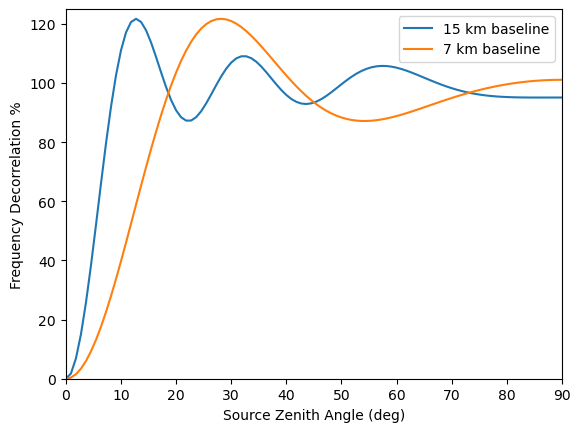

In [117]:
plt.plot(source_zas / np.pi * 180, decorr_values_15km * 100, label="15 km baseline")
plt.plot(source_zas / np.pi * 180, decorr_values_7km * 100, label="7 km baseline")
plt.xlim(0, 90)
plt.ylim(0, 125)
plt.xlabel("Source Zenith Angle (deg)")
plt.ylabel("Frequency Decorrelation %")
plt.legend()
plt.show()

In [118]:
source_ra_offset_list = np.linspace(-6, 6, num=200)
source_dec_deg_list = np.linspace(39.25 - 90, 90, num=200)
source_ra_offset_hrs, source_dec_degs = np.meshgrid(source_ra_offset_list, source_dec_deg_list)

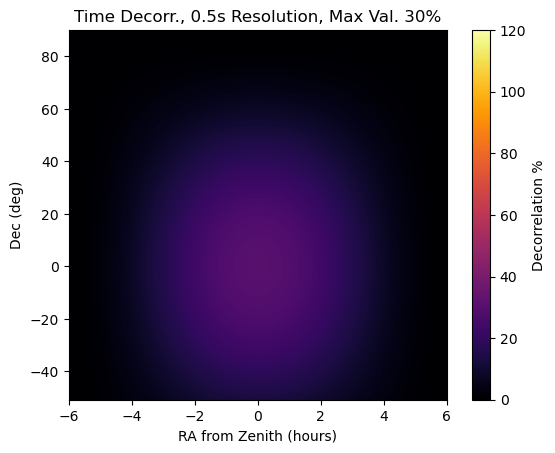

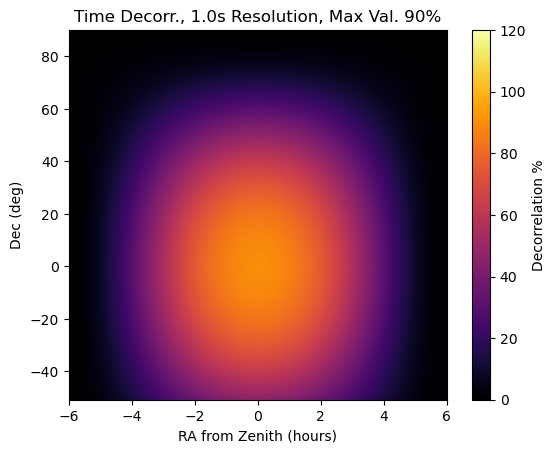

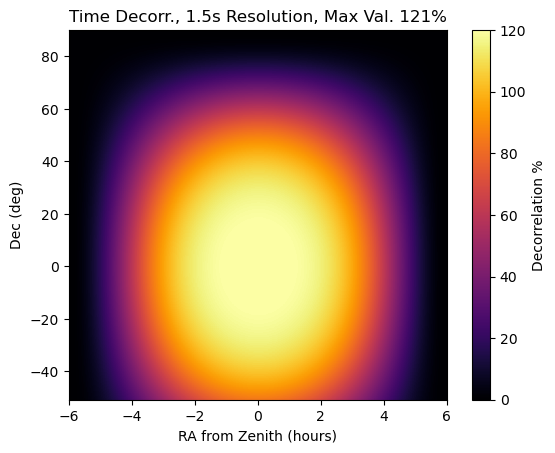

In [119]:
for use_time_resolution_s in np.linspace(0.5, 1.5, num=3):

    decorr_values = time_decorrelation(
        use_time_resolution_s,
        freq_hz,
        15e3,
        0,
        source_ra_offset_hrs,  # Difference between zenith and source RAs
        source_dec_degs,  # Difference between zenith and source RAs
        telescope_lat_deg=39.25,
        omega=7.27e-5,
        c=3e8,
    )

    plt.imshow(
        decorr_values*100,
        origin="lower",
        cmap="inferno",
        interpolation=None,
        extent=(
            np.min(source_ra_offset_list),
            np.max(source_ra_offset_list),
            np.min(source_dec_deg_list),
            np.max(source_dec_deg_list),
        ),
        vmin=0,
        vmax=120,
        aspect=1/12,
    )
    plt.xlabel("RA from Zenith (hours)")
    plt.ylabel("Dec (deg)")
    plt.colorbar(label="Decorrelation %")
    plt.title(
        f"Time Decorr., {use_time_resolution_s}s Resolution, Max Val. {int(np.max(decorr_values*100))}%"
    )
    plt.show()
    #plt.savefig(f"/Users/ruby/Downloads/time_decorr_{use_time_resolution_s}s.png",dpi=300)
    #plt.close()

In [120]:
print(np.max(decorr_values))

1.2122491090854237


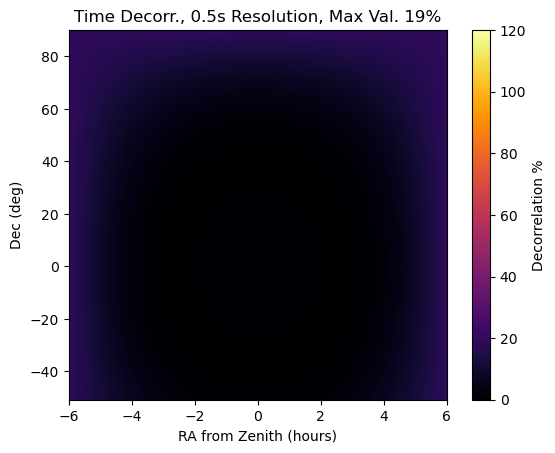

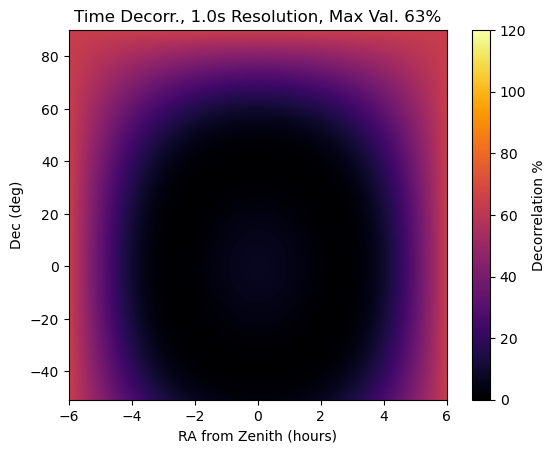

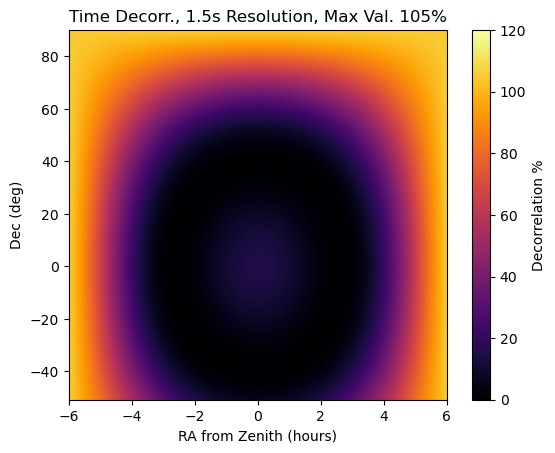

In [121]:
for use_time_resolution_s in np.linspace(0.5, 1.5, num=3):

    decorr_values = time_decorrelation_with_continuous_phase_tracking(
        use_time_resolution_s,
        freq_hz,
        15e3,
        0,
        source_ra_offset_hrs,  # Difference between zenith and source RAs
        source_dec_degs,  # Difference between zenith and source RAs
        telescope_lat_deg=39.25,
        omega=7.27e-5,
        c=3e8,
    )

    plt.imshow(
        decorr_values * 100,
        origin="lower",
        cmap="inferno",
        interpolation=None,
        extent=(
            np.min(source_ra_offset_list),
            np.max(source_ra_offset_list),
            np.min(source_dec_deg_list),
            np.max(source_dec_deg_list),
        ),
        vmin=0,
        vmax=120,
        aspect=1 / 12,
    )
    plt.xlabel("RA from Zenith (hours)")
    plt.ylabel("Dec (deg)")
    plt.colorbar(label="Decorrelation %")
    plt.title(
        f"Time Decorr., {use_time_resolution_s}s Resolution, Max Val. {int(np.max(decorr_values*100))}%"
    )
    plt.show()
    # plt.savefig(f"/Users/ruby/Downloads/time_decorr_{use_time_resolution_s}s.png",dpi=300)
    # plt.close()

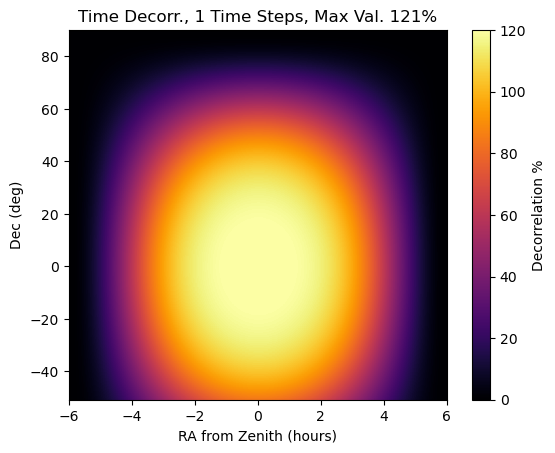

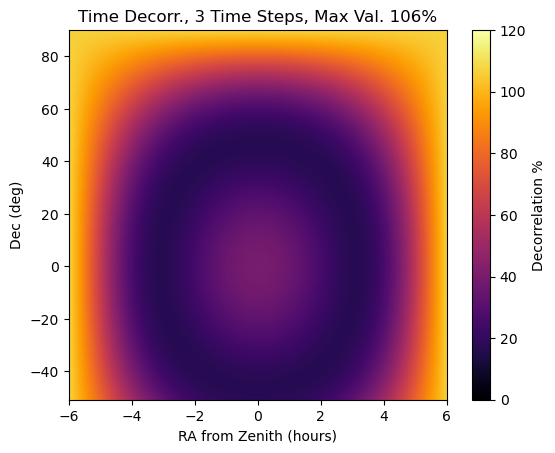

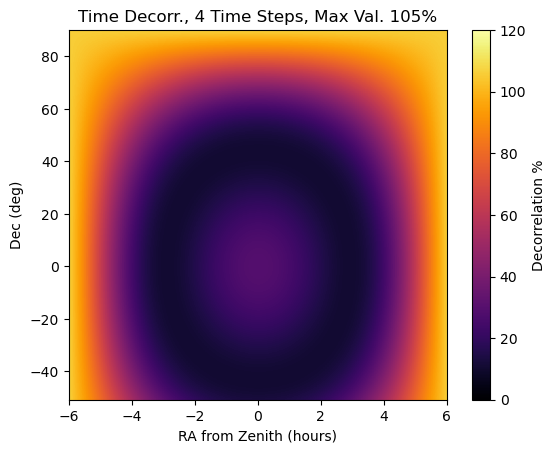

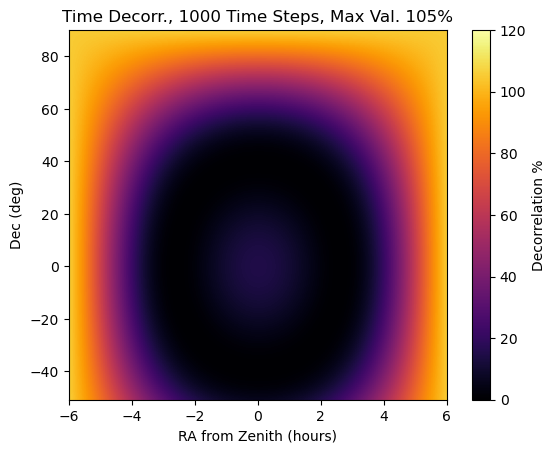

In [122]:
total_time_interval_s = 1.5
for n_time_steps in [1, 3, 4, 1000]:
    decorr_values = time_decorrelation_with_discrete_phase_tracking(
        total_time_interval_s,
        n_time_steps,
        freq_hz,
        15e3,
        0,
        source_ra_offset_hrs,  # Difference between zenith and source RAs
        source_dec_degs,  # Difference between zenith and source RAs
        telescope_lat_deg=39.25,
        omega=7.27e-5,
        c=3e8,
    )

    plt.imshow(
        decorr_values * 100,
        origin="lower",
        cmap="inferno",
        interpolation=None,
        extent=(
            np.min(source_ra_offset_list),
            np.max(source_ra_offset_list),
            np.min(source_dec_deg_list),
            np.max(source_dec_deg_list),
        ),
        vmin=0,
        vmax=120,
        aspect=1 / 12,
    )
    plt.xlabel("RA from Zenith (hours)")
    plt.ylabel("Dec (deg)")
    plt.colorbar(label="Decorrelation %")
    plt.title(
        f"Time Decorr., {n_time_steps} Time Steps, Max Val. {int(np.max(decorr_values*100))}%"
    )
    plt.show()

/var/folders/x0/sh3xmymj56x6t_05l6hx76zw0000gn/T/ipykernel_24664/3785329682.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  use_cmap = matplotlib.cm.get_cmap("inferno").copy()


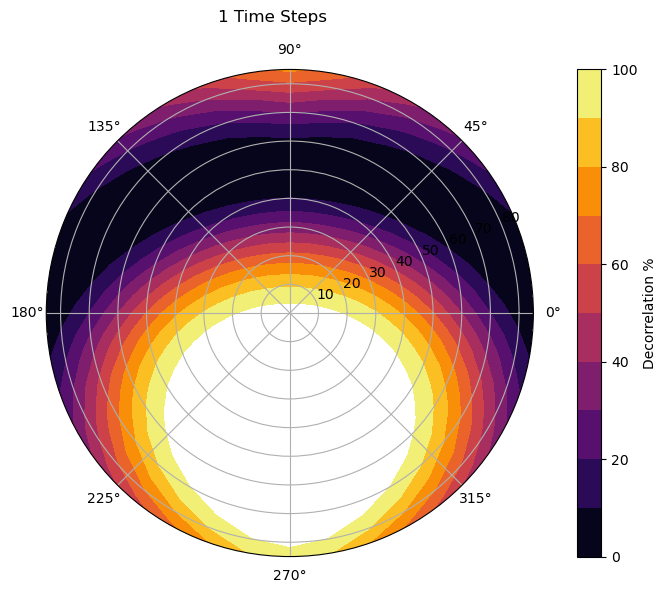

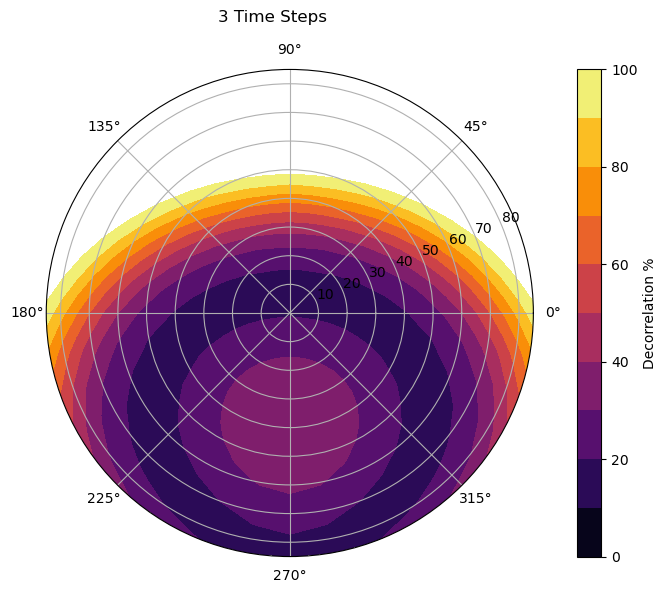

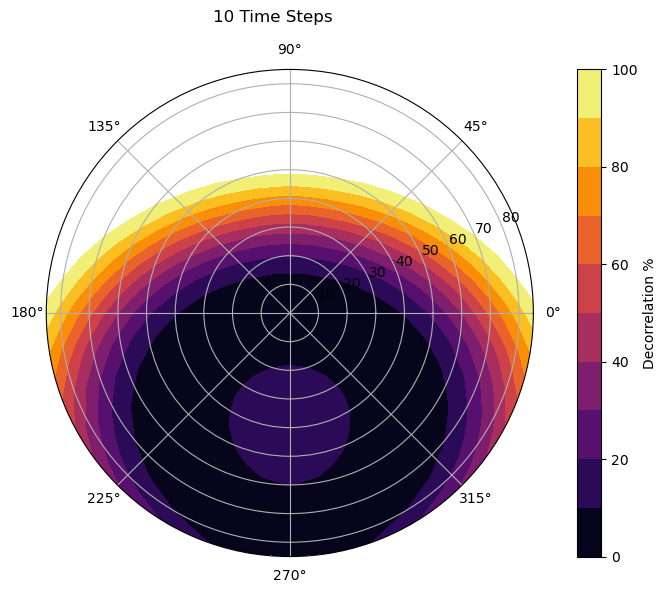

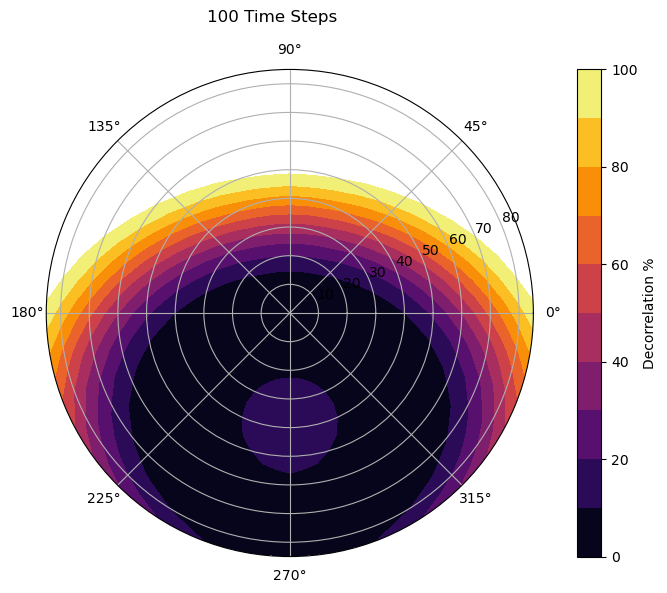

In [183]:
za_vals = np.arange(0, 90, 5)
az_vals = np.arange(0, 370, 10)
az_array, za_array = np.meshgrid(az_vals, za_vals)
ra_vals, dec_vals = az_za_to_ra_dec(
    az_array,  # Units degrees
    za_array,  # Units degrees
    0,  # Units hours
    39.25,  # Units degrees
)

for time_steps in [1, 3, 10, 100]:

    decorr_values = time_decorrelation_with_discrete_phase_tracking(
        1.5,
        time_steps,
        freq_hz,
        15e3,
        0,
        ra_vals,  # Difference between zenith and source RAs
        dec_vals,  # Difference between zenith and source RAs
        telescope_lat_deg=39.25,
        omega=7.27e-5,
        c=3e8,
    )
    make_polar_contour_plot(
        decorr_values * 100,
        np.deg2rad(az_vals),  # Units radians
        za_vals,  # Units degrees
        vmin=0,
        vmax=100,
        ncontours=11,
        title=f"{time_steps} Time Steps",
    )